<a href="https://colab.research.google.com/github/cjakuc/DS-Unit2_Build-Week/blob/master/Data%20Cleaning%20and%20Modeling/LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
!pip install category_encoders==2.*
!pip install pdpbox
!pip install eli5
!pip install shap

     |████████████████████████████████| 102kB 2.4MB/s 
     |████████████████████████████████| 57.7MB 68kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=5dbe7677655acd339f1689c2144976963491e92cac468172d11d76b4f4c11d85
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 112kB 3.5MB/s 
     |████████████████████████████████| 276kB 3.4MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394149 sha256=0d00d1775312a765362acc7e4006596c14f16caae706bbc4e21adfd912ba73ab
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
# Import data
df = pd.read_csv('https://github.com/cjakuc/DS-Unit2_Build-Week/blob/master/Data/BuildWeek2FinalData.csv?raw=true',
                 infer_datetime_format=True,
                 index_col=0)

In [0]:
df.head()

,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWindDirection,HourlyWindSpeed,year,month,date,hour,season,MW,DailyAvgAirTemp,DailyCoolingDegreeDays,DailyHeatingDegreeDays
2005-01-01,50.000000,50.000000,0.0,100.0,30.300,29.215000,1.500,225.000000,11.500000,2005,1,1,0,winter,1560.0,48.0,0.0,17.0
2005-01-01,50.833333,50.833333,0.0,100.0,30.305,29.223333,1.415,226.666667,8.666667,2005,1,1,1,winter,1490.0,48.0,0.0,17.0
2005-01-01,50.000000,50.000000,0.0,100.0,30.320,29.240000,0.250,200.000000,6.000000,2005,1,1,2,winter,1429.0,48.0,0.0,17.0
2005-01-01,50.000000,50.000000,0.0,100.0,30.340,29.250000,0.250,200.000000,3.000000,2005,1,1,3,winter,1367.0,48.0,0.0,17.0
2005-01-01,50.000000,50.000000,0.0,100.0,30.340,29.255000,0.250,100.000000,1.500000,2005,1,1,4,winter,1325.0,48.0,0.0,17.0


In [0]:
# Lagged variables add NaN values which don't allow for getting the permutation importance
# Unsure how to handle this
def wrangle(X):
  """Wrangle train, validate, and test in the same way"""

  X = X.copy()

  # Add lagged variables
  X['DailyAvgAirTemp_lag1'] = X['DailyAvgAirTemp'].shift()
  X['DailyHeatingDegreeDays_lag1'] = X['DailyHeatingDegreeDays'].shift()
  X['DailyCoolingDegreeDays_lag1'] = X['DailyCoolingDegreeDays'].shift()
  X['DailyHeatingDegreeDays_lag24'] = X['DailyHeatingDegreeDays'].shift(24)
  X['DailyCoolingDegreeDays_lag24'] = X['DailyCoolingDegreeDays'].shift(24)
    # These were un-realistic
  X['DailyHeatingDegreeDays_lag365'] = X['DailyHeatingDegreeDays'].shift(365)
  X['DailyCoolingDegreeDays_lag365'] = X['DailyCoolingDegreeDays'].shift(365)
    # These were mostly unhelpful and I'm replacing them w/ vars for degrees
    # over/under 65
  # Degrees over 65
  X['DegOver65'] = [(x - 65) if x > 65 else 0 for x in X['HourlyDryBulbTemperature']]
  # # Degrees under 65
  X['DegUnder65'] = [(65 - x) if x < 65 else 0 for x in X['HourlyDryBulbTemperature']]
  # These didn't help
    # I assume it's because the random forest model automatically takes into
    # account this relationship with just the hourly temperature variable
    # Could be helpful in a linear model though

  X['MW_lag1'] = X['MW'].shift()
  X['MW_lag24'] = X['MW'].shift(24)
  X['MW_lag365'] = X['MW'].shift(365)

  # Drop unattainable/non-helpful info
  X = X.drop(columns=['DailyAvgAirTemp',
                      'DailyHeatingDegreeDays',
                      'DailyCoolingDegreeDays',
                      'month'])

  return X

# Wrangle train, val, and test
df_wrangled = wrangle(df)
# df_wrangled.to_csv('BW2_wrangled.csv')
train_wrangled = df_wrangled[df_wrangled['year']<2014]
val_wrangled = df_wrangled[df_wrangled['year']==2014]
test_wrangled = df_wrangled[df_wrangled['year']==2015]

In [0]:
df_wrangled.head()

,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWindDirection,HourlyWindSpeed,year,date,hour,season,MW,DailyAvgAirTemp_lag1,DailyHeatingDegreeDays_lag1,DailyCoolingDegreeDays_lag1,DailyHeatingDegreeDays_lag24,DailyCoolingDegreeDays_lag24,DailyHeatingDegreeDays_lag365,DailyCoolingDegreeDays_lag365,DegOver65,DegUnder65,MW_lag1,MW_lag24,MW_lag365
2005-01-01,50.000000,50.000000,0.0,100.0,30.300,29.215000,1.500,225.000000,11.500000,2005,1,0,winter,1560.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,15.000000,NaN,NaN,NaN
2005-01-01,50.833333,50.833333,0.0,100.0,30.305,29.223333,1.415,226.666667,8.666667,2005,1,1,winter,1490.0,48.0,17.0,0.0,NaN,NaN,NaN,NaN,0.0,14.166667,1560.0,NaN,NaN
2005-01-01,50.000000,50.000000,0.0,100.0,30.320,29.240000,0.250,200.000000,6.000000,2005,1,2,winter,1429.0,48.0,17.0,0.0,NaN,NaN,NaN,NaN,0.0,15.000000,1490.0,NaN,NaN
2005-01-01,50.000000,50.000000,0.0,100.0,30.340,29.250000,0.250,200.000000,3.000000,2005,1,3,winter,1367.0,48.0,17.0,0.0,NaN,NaN,NaN,NaN,0.0,15.000000,1429.0,NaN,NaN
2005-01-01,50.000000,50.000000,0.0,100.0,30.340,29.255000,0.250,100.000000,1.500000,2005,1,4,winter,1325.0,48.0,17.0,0.0,NaN,NaN,NaN,NaN,0.0,15.000000,1367.0,NaN,NaN


In [0]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
import eli5
from eli5.sklearn import PermutationImportance
import plotly.express as px

# Build, fit, validate, and visualize the model
def full_model(train,val):
  """Define a function that selects features, encodes,
     and fits a XGBRegressor model
     Returns the model and features"""

  # Select target
  target = 'MW'
  # Drop target from features
  features = train.drop(columns=[target,'HourlySeaLevelPressure','year']).columns.tolist()

  # Arrange X features matrix & y target vector
  X_train = train[features]
  y_train = train[target]
  X_val = val[features]
  y_val = val[target]

  # Encode
  encoder = ce.OrdinalEncoder()
  X_train_encoded = encoder.fit_transform(X_train)
  X_val_encoded = encoder.transform(X_val)

  # Build model
  model = XGBRegressor(n_estimators=1000,
                       max_depth=6,
                       random_state=42,
                       learning_rate=0.5,
                       n_jobs=-1,
                       verbosity=0)
  # Fit model
  eval_set = [(X_train_encoded, y_train), 
              (X_val_encoded, y_val)]

  model.fit(X_train_encoded, y_train, 
            eval_set=eval_set, 
            eval_metric='mae', 
            early_stopping_rounds=50,
            verbose=False)
  
  # Print scores
  print(f'XGB best iterations: {model.best_iteration}')
  print('Train MAE', mean_absolute_error(y_train,model.predict(X_train_encoded)))
  print('Validation MAE', mean_absolute_error(y_val,model.predict(X_val_encoded)))
  print(f'Train R^2 Score: {model.score(X_train_encoded,y_train)}')
  print(f'Validation R^2 Score: {model.score(X_val_encoded,y_val)}\n')

  # Plot the residuals
  # errors = (y_val - model.predict(X_val_encoded))
  # sns.scatterplot(x=y_val,y=errors,alpha=0.1)
  # # Add a horizontal line at residuals = 0
  # plt.hlines(y=0,xmin=1000,xmax=3200,color='red');
  # plt.title('Residuals vs Validation Target')
  # plt.ylabel('Residuals (MW)')
  # plt.xlabel('Validation Target (MW)')
  # plt.show()

  # Plot residuals w/ plotly express
#   errors = (y_val - model.predict(X_val_encoded))
#   fig = px.scatter(x=y_val, y=errors, opacity=0.3,
#                    labels={'x':'Test Set Actual Values(MW)','y':'Residuals (MW)'},
#                    template='plotly_dark')
#  # Add a title
#   title = {'xref':'paper', 'yref':'paper', 'x':0.0,'xanchor':'left',
#           'yanchor':'bottom',
#           'text':'Prediction Residuals',
#           'font':dict(family='Arial',
#                       size=20)}
#   fig.update_layout(title=title)
#   # Add horizontal red line
#   h_line = []
#   h_line.append(dict(
#       type= 'line',
#       yref= 'y', y0= 0, y1= 0,
#       xref= 'paper', x0= 0, x1= 1,
#       line=dict(color='red'),
#       name='Residuals = 0'
#       ))
#   fig.update_layout(shapes=h_line)
#   fig.show()


  # Plot the predicted vs the actual
  # import matplotlib.lines as mlines
  # blue_line = mlines.Line2D([],[],color='#2077B4',
  #                           linewidth=3)
  # orange_line = mlines.Line2D([],[],color='#FC7F0F',
  #                             linewidth=3)
  # sns.lineplot(x=val['date'],y=val['MW'])
  # sns.lineplot(x=val['date'],y=model.predict(X_val_encoded))
  # plt.title('Actual vs Predicted Values')
  # # Create the legend
  # plt.legend(handles=[blue_line,
  #                     orange_line],
  #            labels=['Actual',
  #                    'Predicted']);
  
  # Plot predicted vs actual using plotly express
  df_actual = pd.DataFrame(data={'date':val['date'],'value':val['MW'],'is_actual':True})
  df_predicted = pd.DataFrame(data={'date':val['date'],'value':model.predict(X_val_encoded),'is_actual':False})
  df_ap = pd.concat([df_actual,df_predicted],ignore_index=True)
  fig = px.line(data_frame=df_ap, x='date', y='value', color='is_actual',
                labels={'date':'Day of the Year',
                        'value':'MW',
                        'is_actual':'Is the actual value'},
                template='plotly_dark')
  # Add a title
  title = {'xref':'paper', 'yref':'paper', 'x':0.0,'xanchor':'left',
          'yanchor':'bottom',
          'text':'Actual vs Predicted MW (2015)',
          'font':dict(family='Arial',
                      size=20)}
  fig.update_layout(title=title)

  season_x_labels=['January 1st',
                  'February 19th',
                  'April 10th',
                  'May 30th',
                  'July 19th',
                  'September 7th',
                  'October 27th',
                  'December 16th']
  season_x_ticks = [1,50,100,150,200,250,300,350]
  fig.update_xaxes(
      tickvals=season_x_ticks,
      ticktext=season_x_labels,
      tickangle=15
  )

  # Add footer
  annotations = []
  annotations.append(dict(xref='paper', yref='paper', x=-0.1, y=-0.25,
                                xanchor='left', yanchor='bottom',
                                text='Click on legend values to adjust figure',
                                font=dict(family='Arial',
                                          size=12,
                                          color='gray'),
                                showarrow=False))
  fig.update_layout(annotations=annotations)
  fig.show()


  # Show the permutation importances
  # permuter = PermutationImportance(
  #     model, 
  #     scoring='neg_mean_absolute_error', 
  #     n_iter=5, 
  #     random_state=42
  # )
  # permuter.fit(X_val_encoded, y_val)
  # feature_names = X_val_encoded.columns.tolist()
  # permutation_importances = eli5.show_weights(
  #     permuter, 
  #     top=None, # No limit: show permutation importances for all features
  #     feature_names=feature_names # must be a list
  # )
  # permutation_importances

  # return model, features, permutation_importances
  return model, features

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [0]:
model, features = full_model(train_wrangled,
                             val_wrangled)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



XGB best iterations: 259
Train MAE 12.205561287786864
Validation MAE 18.935221716475812
Train R^2 Score: 0.9983320401771398
Validation R^2 Score: 0.9954993947319072



In [0]:
# model, features, permutation_importances = full_model(train_wrangled,
#                                                       val_wrangled)
# permutation_importances

In [0]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 80

In [0]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(train_wrangled[features])
X_val_encoded = encoder.transform(val_wrangled[features])

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'hour'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

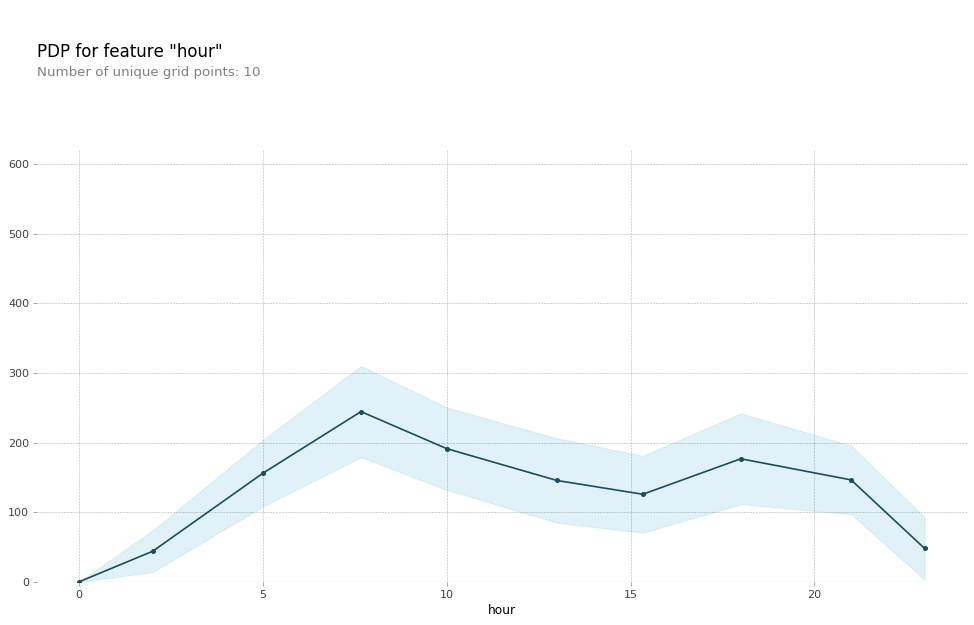

In [0]:
pdp_plot(isolated, feature_name=feature);

In [0]:
# Get an individual observation to explain.
row = X_val_encoded.iloc[[8591]] 
row

,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindDirection,HourlyWindSpeed,date,hour,season,DailyAvgAirTemp_lag1,DailyHeatingDegreeDays_lag1,DailyCoolingDegreeDays_lag1,DailyHeatingDegreeDays_lag24,DailyCoolingDegreeDays_lag24,DailyHeatingDegreeDays_lag365,DailyCoolingDegreeDays_lag365,DegOver65,DegUnder65,MW_lag1,MW_lag24,MW_lag365
2014-12-24,35.0,39.0,0.0,86.0,28.63,10.0,230.0,16.0,358,23,1,47.0,18.0,0.0,15.0,0.0,26.0,0.0,0.0,26.0,1754.0,1783.0,2403.0


In [0]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)

 # TODO for the future:

Feature Engineering
- Remove the hourly and daily lags to simulate real forecasting
- Add weekend or non-weekend variable
- Add holidays variable for holidays with large affect on MW
- Add interactions between hours and seasons
- Drop year?
- Is adding a feature "average MW per hour per day" the same as interactions between date and hour?
- Add features for degrees above/below 65

Modelling
- Try a LOESS regression
  - On a daily seasonality
  - On a seasonal seasonality